# Main Figure 2: Primary vs secondary infections

This notebook creates the second figure in our publication. Where we explore secondary infections related to the UEFA2020 championship.


In [2]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import pymc3 as pm
import colorsys
sys.path.append("../")
sys.path.append("../covid19_inference")


# Matplotlib config
from header_plotting import *

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from covid19_inference.plot import _format_date_xticks

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
""" General configs
"""
fig_path = "./figures"
country = "England"
xlim_ts = [datetime.datetime(2021,5,30),datetime.datetime(2021,7,23)] # Plotting range
tune = 1000
draws = 1500 
max_treedepth = 12
offset = 0 #offset of soccer games, mainly for sanity checks
width_prior_delay = 0.1

# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

## Normal trace (with UEFA2020 effect)

In [5]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

model= None
fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_publication_traces/"+
    f"-beta=False"+
    f"-country={country}"+
    f"-offset_data=0"+
    f"-prior_delay=-1"+
    f"-width_delay_prior=0.1"+
    f"-sigma_incubation=-1.0"+
    f"-median_width_delay=1.0"+
    f"-interval_cps=10.0"+
    f"-f_fem=0.2"+
    f"-uc=True"
    f"-len=normal"+                    
    f"-t={tune}"+
    f"-d={draws}"+
    f"-max_treedepth={max_treedepth}.pkl")

if os.path.exists(fstr(4000, 8000, 12)):
    try:
        model, trace = load(fstr(4000, 8000, 12))
        print(f"Use 8000 sample runs for {country}")
    except:
        pass
if model is None and os.path.exists(fstr(2000, 4000, 12)):
    try:
        model, trace = load(fstr(2000, 4000, 12))
        print(f"Use 4000 sample runs for {country}")
    except:
        pass
if model is None and os.path.exists(fstr(1000, 1500, 12)):
    try: 
        model, trace = load(fstr(1000, 1500, 12))
        print(f"Use 1500 sample runs for {country}")
    except:
        pass
if model is None: 
    print(fstr(tune, draws, max_treedepth), " not found")
dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])

Use 1500 sample runs for England


## Load data
This script requires some additional model runs, these can be genereated using the script `/primary_vs_secondary/primary_vs_secondary.py`.

In [6]:
trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_publication_traces/primary_vs_secondary/{country}.pkl")

## Plotting

In [7]:
from covid19_soccer.plot.rcParams import rcParams
from covid19_soccer.plot.utils import lighten_color
from matplotlib.patches import Patch, Rectangle
from covid19_soccer.plot.other import HandlerRect, MulticolorPatchHandler,MulticolorPatch, Line2D
from matplotlib.colors import to_hex
import matplotlib.ticker as ticker

from covid19_soccer.plot import timeseries

def plot_corr(ax,GamesXCountry,models):
    x = np.arange(0,np.max(GamesXCountry)+1,0.1)
    # Get y values
    y = []
    for model in models:
        y.append(model.predict(x.reshape(-1,1)))
    y = np.array(y)

    # Compute mean and ci
    mean_mod = y.mean(axis=0)
    p025_mod = np.percentile(y, 2.5,axis=0)
    p975_mod = np.percentile(y,97.5,axis=0)

    # Plot error bars
    lines = ax.vlines(
        x=GamesXCountry,
        ymin=p025,
        ymax=p975,
        lw=2,
        zorder=9,
        color="#060434",
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=GamesXCountry,
        y=mean,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )

    # Plot model fit
    ax.plot(x,mean_mod,color="#009988",lw=1)
    ax.fill_between(x,p025_mod,p975_mod,color="#009988",alpha=0.2)


def plot_legend(ax,loc="upper left"):
    """ Plot the legend onto an axis
    Parameters
    ----------
    ax: mpl axis
    loc: strin
        Location of the legend
    """
    # Legend
    handles = []
    labels = []
    handles.append(ax.get_legend_handles_labels()[0][0])
    labels.append("Cases:")


    handles.append(MulticolorPatch([colors_base[0]]))
    labels.append("   indepentent of the EURO 2020")

    handles.append(MulticolorPatch([colors_base[1]]))
    labels.append("   primary due to the EURO 2020")

    handles.append(MulticolorPatch([colors_base[2]]))
    labels.append("   subsequent due to the EURO 2020")

    handles.append(Line2D(
                [0],
                [0],
                color="black",
                ls="--",
                lw=2,
            ))
    labels.append("   observed total") 

    handles.append(Rectangle([0,0],width=1, height=2.2, lw=1, edgecolor=rcParams.color_championship_range,hatch="////",facecolor = 'none'))
    labels.append("Time window of\nthe championship") 



    ax.legend(
        handles,
        labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), Rectangle: HandlerRect(),},
        loc=loc,
    )
    return ax

    
# Data

shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
x = pd.date_range(model.sim_begin, model.sim_end)
y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0)
y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y0
y2 = trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]).mean(axis=0) - y1 - y0

# Stack and convert to incidence
y = [
    y0[:,0]+y0[:,1],
    y1[:,0]+y1[:,1],
    y2[:,0]+y2[:,1]
]

# Colors
colors_base = ["#fe904c","#92b0ff","#e667a5"]
l = 0.9
d = 1.1

colors_mf = []
for i,col in enumerate(colors_base):
    colors_mf.append(to_hex(lighten_color(col,d)))
    colors_mf.append(to_hex(lighten_color(col,l)))
colors_mf = np.array(colors_mf)


In [8]:
# Load data for 2nd plot see effect_vs_nGames.ipynb
import pickle
nGames, modelsLin,[mean,p025,p975] = pickle.load(open( fig_path+"/effect_vs_nGames.pkl","rb"))

WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found

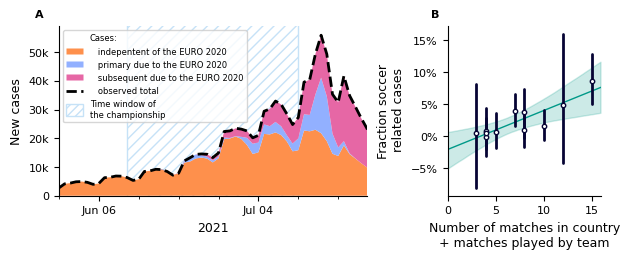

In [9]:
import string
from covid19_soccer.plot.timeseries import _uefa_range
from covid19_soccer.plot.utils import k_formatter
from covid19_soccer.plot.other import format_date_axis
# Plot data
fig, axes = plt.subplots(1,2,figsize=(7,2.2),gridspec_kw={"width_ratios":[2,1], "wspace":0.35})

ax = axes[0]
ax.plot([], [], alpha=0, label="a")

"""Panel A
"""
# Show time of uefa championship
_uefa_range(ax)

timeseries.stacked_filled(x,y,ax=ax, colors=colors_base, label="b")
timeseries._timeseries(x,np.sum(y,axis=0),ax=ax,what="model",color="black",label="c",ls="--",lw=2)

# Markup
ax.set_xlim(*xlim_ts)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(k_formatter))
ax.set_ylim(0,59000)
ax.set_xlabel("2021")
ax.set_ylabel("New cases")
plot_legend(ax)
format_date_axis(ax)

"""Panel B
"""
plot_corr(axes[1],nGames,modelsLin)
axes[1].set_ylabel("Fraction soccer\n related cases")
axes[1].set_xlabel("Number of matches in country\n+ matches played by team")
axes[1].yaxis.set_major_formatter(ticker.PercentFormatter(1.0,0))
axes[1].set_xlim(0,16)


#Add axes annotations
alphabet_string = list(string.ascii_uppercase)
for i, ax in enumerate(axes):
    letter = alphabet_string[i]
    ax.text(-0.05, 1.1, letter, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')

plt.show()

fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}_a.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}_a.png", **save_kwargs)
plt.close(fig=fig)

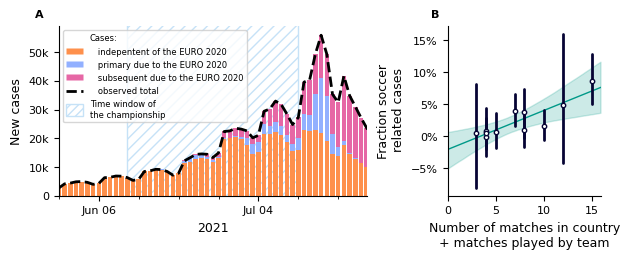

In [10]:
# Plot data
fig, axes = plt.subplots(1,2,figsize=(7,2.2),gridspec_kw={"width_ratios":[2,1], "wspace":0.35})

ax = axes[0]
ax.plot([], [], alpha=0, label="a")

timeseries.stacked_bars(x,y,ax=ax, colors=colors_base,label="b",width=0.8,date_format=False)
timeseries._timeseries(x,np.sum(y,axis=0),ax=ax,what="model",color="black",label="c",ls="--",lw=2)



# Show time of uefa championship
_uefa_range(ax)

# Markup
ax.set_xlim(*xlim_ts)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(k_formatter))
ax.set_ylim(0,59000)
ax.set_xlabel("2021")
ax.set_ylabel("New cases")

plot_legend(ax)
format_date_axis(ax)
# Panel B
plot_corr(axes[1],nGames,modelsLin)
axes[1].set_ylabel("Fraction soccer\n related cases")
axes[1].set_xlabel("Number of matches in country\n+ matches played by team")
axes[1].yaxis.set_major_formatter(ticker.PercentFormatter(1.0,0))
axes[1].set_xlim(0,16)


#Add axes annotations
alphabet_string = list(string.ascii_uppercase)
for i, ax in enumerate(axes):
    letter = alphabet_string[i]
    ax.text(-0.05, 1.1, letter, transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')

plt.show()

fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}_b.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/primary_vs_infections_chains_{country}_b.png", **save_kwargs)
plt.close(fig=fig)

## Si plots

Additionally we create an overview plot for all countries.

In [11]:
# Extract data
countries = [
    "England",
    "Scotland",
    "Germany",
    "France",
    "Spain",
    "Slovakia",
    "Portugal",
    "Netherlands",
    "Italy",
    "Czechia",
    "Belgium",
    "Austria",
]

# Shapes: (sample,gender)
infections_no = []
infections_primary = []
infections_secondary = []
dls = []
for country in countries:
    model= None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_publication_traces/"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-width_delay_prior=0.1"+
        f"-sigma_incubation=-1.0"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.2"+
        f"-uc=True"
        f"-len=normal"+                    
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")

    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")

    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
        
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_publication_traces/primary_vs_secondary/{country}.pkl")
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    dls.append(dl)

    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(model.sim_begin, model.sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4])
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y0
    y2 = trace.posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    total = y0 + y1 + y2

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_secondary.append(y2)


Use 1500 sample runs for England
Use 8000 sample runs for Scotland
Use 8000 sample runs for Germany
Use 4000 sample runs for France
Use 8000 sample runs for Spain
Use 8000 sample runs for Slovakia
Use 4000 sample runs for Portugal
Use 8000 sample runs for Netherlands
Use 8000 sample runs for Italy
Use 8000 sample runs for Czechia
Use 8000 sample runs for Belgium
Use 8000 sample runs for Austria


Process data for easier plotting and the table

In [16]:
import seaborn as sns

data_primary  = pd.DataFrame()
means = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    means.append(np.mean(temp["percentage_primary"]))

country_order_primar = np.argsort(means)[::-1]

data_primary_and_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_secondary[i])/(infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    means.append(np.mean(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(means)[::-1]


# As the conctac matrix is symmetric for the subsequant infections we can just plot the violin plots
data_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = infections_secondary[i].sum(axis=-1)/(infections_no[i] + infections_primary[i] + infections_secondary[i]).sum(axis=-1) * 100

    # Create dataframe for plotting
    temp = pd.DataFrame(t_numpy, columns=["percentage_secondary"])
    temp["country"] = country
    data_subsequent = pd.concat([data_subsequent, temp])
    means.append(np.median(temp["percentage_secondary"]))

country_order_subsequent = np.argsort(means)[::-1]


/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:786: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(
/home/smohr/Repositories/covid19_soccer/notebooks/../covid19_soccer/plot/other.py:797: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Patch(


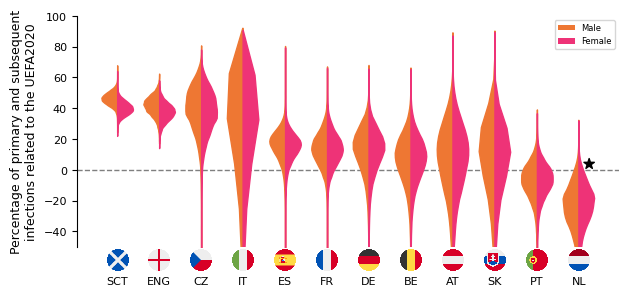

In [17]:
from covid19_soccer.plot.rcParams import *
from covid19_soccer.plot.utils import get_flag
from covid19_soccer.plot.other import legend
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


fig, ax = plt.subplots(1, 1, figsize=(7, 3))

color_male = rcParams.color_male
color_female = rcParams.color_female
"""
sns.violinplot(
    data=data_primary,
    y="percentage_primary",
    x="country",
    hue="gender",
    scale="count",
    inner=None,
    orient="v",
    split=True,
    linewidth=1,
    saturation=1,
    width=0.75,
    palette={"male": color_male, "female": color_female},
    order=np.array(countries)[country_order],
    ax=ax
)
"""

sns.violinplot(
    data=data_primary_and_subsequent,
    y="percentage_primary_and_subsequent",
    x="country",
    hue="gender",
    scale="count",
    inner=None,
    split=True,
    orient="v",
    linewidth=1,
    saturation=1,
    width=0.75,
    bw=0.1,
    order=np.array(countries)[country_order_primary_and_subsequent],
    ax=ax,
    legend = False,
    cut=0,
)

ax.set_ylim(-50,100)

# Remove legend
ax.legend([], [], frameon=False)

color1 = colors_base[0]
color2 = colors_base[1]

for i, col in enumerate(ax.collections):
    if i % 2 == 0:
        ax.collections[i].set_edgecolor(color_male)  # Set outline colors
        ax.collections[i].set_facecolor(color_male)
    else:
        ax.collections[i].set_edgecolor(color_female)  # Set outline colors
        ax.collections[i].set_facecolor(color_female)


""" Markup
"""
ax.set_ylabel("Percentage of primary and subsequent\ninfections related to the UEFA2020")
ax.set_xlabel("")
ax.set_xticklabels(country_order_primary_and_subsequent)

# plot flags if desired
plot_flags = True
if plot_flags:
    iso2 = []
    for i, dl in enumerate(np.array(dls)[country_order_primary_and_subsequent]):
        t_iso2 = dl.countries_iso2[0].replace("GB-", "")
        iso2.append(t_iso2)
        img = plt.imread(get_flag(dl.countries_iso2[0].lower()))
        im = OffsetImage(img, zoom=0.03)
        im.image.axes = ax
        ab = AnnotationBbox(
            im,
            (i, -50),
            xybox=(0.0, -10.0),
            frameon=False,
            xycoords="data",
            boxcoords="offset points",
            pad=0,
        )
        ax.add_artist(ab)
    ax.set_xticklabels(iso2)
    ax.tick_params(axis="x", which="major", pad=21, length=0)

ax.axhline(0, color="tab:gray", ls="--", zorder=-5, lw=1)

# Place star at netherlands
ax.scatter(11.2,3,marker='$\star$',color="black",s=100)
ax.spines["bottom"].set_visible(False)
legend(ax,False,False,False,False,True,False,loc="upper right")

plt.show()
fig.savefig(f"{fig_path}/primary_and_subsequent.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/primary_and_subsequent.png", **save_kwargs)
plt.close(fig=fig)

In [37]:
table = []
for i, country in enumerate(np.array(countries)[country_order_primar]):
  # Primary infections
  data  = data_primary[data_primary["country"] == country]

  CI = np.percentile(data["percentage_primary"], q = (2.5,50,97.5))
  prob_positive = np.sum(data["percentage_primary"] > 0) / data["percentage_primary"].shape[0] * 100

  # Secondary infections and primary
  data  = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country]
  CI_sub = np.percentile(data["percentage_primary_and_subsequent"], q = (2.5,50,97.5))
  print(CI_sub)
  # Create table entries
  if prob_positive > 99.9:
      text_prob_pos = "$> 99.9$\%"
  else:
      text_prob_pos = f"{prob_positive:.1f}\%"
  
  table.append([country, f"{CI[1]:.1f}\% (CI: [{CI[0]:.1f}\%, {CI[2]:.1f}\%])", text_prob_pos,
              f"{CI_sub[1]:.1f}\% (CI: [{CI_sub[0]:.1f}\%, {CI_sub[2]:.1f}\%])"])

[26.33222851 39.75015027 52.27913142]
[32.91138689 43.2758124  53.16532276]
[ 5.2869632  39.33390109 63.67932173]
[-95.27268919  31.44788684  74.01410017]
[-9.0840685  16.0797847  33.03344342]
[-27.88577291  13.19554826  36.91255535]
[-82.45188261   8.52403077  47.05765248]
[-33.31672738   7.21204567  34.7180048 ]
[-55.35583234   7.76399207  46.25571521]
[-9.94698224 13.44028459 35.06476645]
[-34.88639784  -6.63713187  13.96920556]
[-79.97823718 -23.85600991   2.54928992]


In [36]:
from tabulate import tabulate
headers = ['Country', 'median fraction soccer related cases', 'probability soccer increased cases', "fraction secondary infections until 31.07.2021"]
print(tabulate(table, headers, tablefmt="latex_raw"))

\begin{tabular}{llll}
\hline
 Country     & median fraction soccer related cases   & probability soccer increased cases   & fraction secondary infections until 31.07.2021   \\
\hline
 England     & 8.4\% (CI: [4.0\%, 15.9\%])            & $> 99.9$\%                           & 39.8\% (CI: [26.3\%, 52.3\%])                    \\
 Scotland    & 4.2\% (CI: [1.4\%, 10.2\%])            & $> 99.9$\%                           & 43.3\% (CI: [32.9\%, 53.2\%])                    \\
 Czechia     & 4.3\% (CI: [0.4\%, 13.9\%])            & 98.9\%                               & 39.3\% (CI: [5.3\%, 63.7\%])                     \\
 Italy       & 2.3\% (CI: [-2.6\%, 12.4\%])           & 87.0\%                               & 31.4\% (CI: [-95.3\%, 74.0\%])                   \\
 Spain       & 1.0\% (CI: [-0.3\%, 4.0\%])            & 94.6\%                               & 16.1\% (CI: [-9.1\%, 33.0\%])                    \\
 Germany     & 0.5\% (CI: [-1.4\%, 3.4\%])            & 79.5\%                    